# Topog form stress using MOM025 DATA

Recent update 27 Aug 2017

In [51]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle
from numpy import math

import dask
from dask import delayed
import dask.array as da
import dask.dataframe as dd
from dask.multiprocessing import get
from dask.async import get_sync
from dask.diagnostics import ProgressBar

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid

#import datashader

# Topographic Stress term comparing


# $$F_{topog} = \int_x  P_{bot}*dH$$
#### with new dH    $dH_{n+1} = (H_{n+2}-H_{n})/2$

In [252]:
## Load data

%time
OceanFile1 = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup4/output008/ocean/ocean_grid.nc'
dsx1 = xr.open_dataset(OceanFile1, engine='netcdf4')
depth = dsx1.ht   ## H
dxu = dsx1.dxu ## dxu

OceanFile2 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup4/output008/ocean/ocean_month.nc'
dsx2 = xr.open_dataset(OceanFile2, engine='netcdf4')
taux = dxu*dsx2.tau_x.mean('time')  ## tau_x
pbot = dsx2.pbot_t.mean('time')     ## p_bot
eta0 = dsx2.eta_t.mean('time') ## \eta
eta = dsx2.sea_level.mean('time') ## sea_level

OceanFile3 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup4/output008/ocean/ocean.nc'
dsx3 = xr.open_dataset(OceanFile3, engine='netcdf4')
rho = dsx3.rho.mean('time')        ## \rho in-situ
rho0 = dsx3.pot_rho_0.mean('time') ## \rho referred to 0 dbar
rho2 = dsx3.pot_rho_2.mean('time') ## \rho referred to 2000 dbar
dz = dsx3.dzt.mean('time')      ## t-cell thickness
g = 9.8196



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.1 µs


## Q1: t-cell thickness dz at same layer have different values at different location (x,y) ?

In [156]:
## evidence of Q1, or see it from ncview dzt
print dz.isel(yt_ocean=300).isel(st_ocean=0)

<xarray.DataArray 'dzt' (xt_ocean: 1440)>
array([ 10.06755 ,  10.067523,  10.067488, ...,  10.067636,  10.067605,
        10.06758 ])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 -279.1 -278.9 -278.6 ...
    yt_ocean  float64 -44.2
    st_ocean  float64 5.034


## Q2: $h =\int_z dz$ is different from depth read from ht in ocean_grid.nc. why?
## A2: $h =\int_z dz$ is the thickness of water, depth is the depth of ocean floor

(-70, -30)

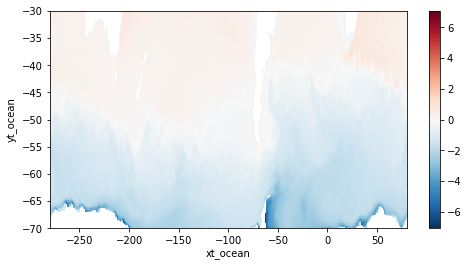

In [193]:
h = dz.sum('st_ocean') ## h = \int_z dz
dh = h-depth           ## dh = h - depth

plt.figure(figsize=(8,4))
dh.plot()
plt.ylim([-70,-30])

(-70, -30)

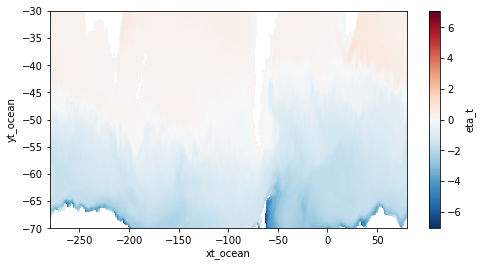

In [174]:
## eta0 is surface height on T-cell
plt.figure(figsize=(8,4))
eta0.plot()
plt.ylim([-70,-30])

(-70, -30)

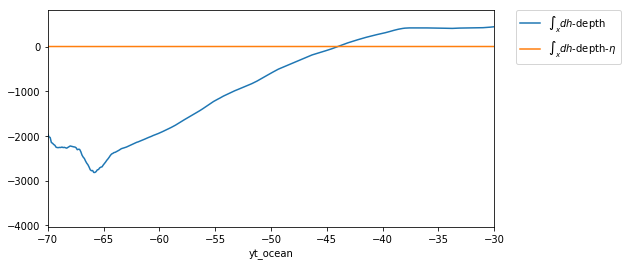

In [244]:
## Check h-depth-eta0, result is ~ 0
h = dz.sum('st_ocean')
dh2 = h-depth-eta0

plt.figure(figsize=(8,4))
dh.sum('xt_ocean').plot(label="$\int_x dh$-depth")  ## \int_x dh
dh2.sum('xt_ocean').plot(label="$\int_x dh$-depth-$\eta$")  ## \int_x dh2
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([-70,-30])

## Q3: pot_rho_0, pot_rho_2, rho (rho in-situ)

In [253]:
## set a new depth 'new_d' change NAN to 0
new_d = np.zeros(depth.shape)
new_d = depth.values
new_d[np.isnan(new_d)]=0

## new_dH using new_d, new_dH(n+1)=new_d(n+2)-new_d(n)
new_dH = np.zeros(depth.shape)
new_dH[:,1:-1] = 0.5*(new_d[:,2:] - new_d[:,:-2])
new_dH[:,0] = 0.5*(new_d[:,1]- new_d[:,-1])
new_dH[:,-1] = 0.5*(new_d[:,0]- new_d[:,-2])

In [254]:
dp0 = rho0*g*dz
p0 = dp0.sum('st_ocean') ## pressure using pot_rho_0

dp2 = rho2*g*dz
p2 = dp2.sum('st_ocean') ## pressure using pot_rho_2

dp = rho*g*dz
p = dp.sum('st_ocean')   ## pressure using rho

(-70, -30)

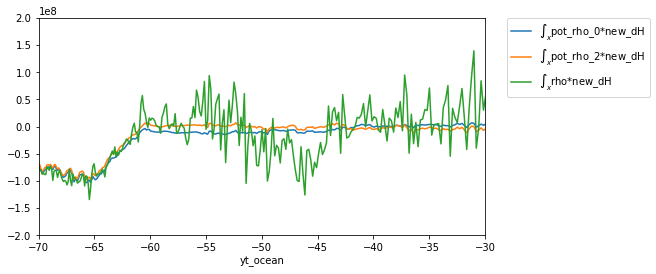

In [255]:
plt.figure(figsize=(8,4))
tmp1 = p0*new_dH    ## p0=pot_rho_0, new_dH generated from depth
tmp2 = p2*new_dH    ## p2=pot_rho_2, new_dH generated from depth
tmp3 = p*new_dH     ## p = rho, new_dH generated from depth
tmp1.sum('xt_ocean').plot(label="$\int_x$pot_rho_0*new_dH")
tmp2.sum('xt_ocean').plot(label="$\int_x$pot_rho_2*new_dH")
tmp3.sum('xt_ocean').plot(label="$\int_x$rho*new_dH") 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([-2e8,2e8])
plt.xlim([-70,-30])

### Comments:
### use different density, the result is different

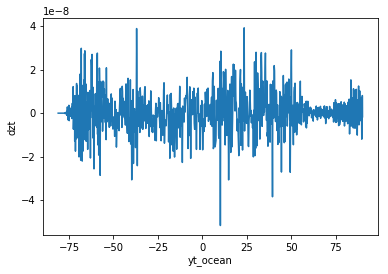

In [256]:
## define h as \int_z dzt
h = dz.sum('st_ocean')

dh = np.zeros(depth.shape)
dh[:,1:-1] = 0.5*(h[:,2:].values - h[:,:-2].values)
dh[:,0] = 0.5*(h[:,1].values- h[:,-1].values)
dh[:,-1] = 0.5*(h[:,0].values- h[:,-2].values)

tmp = h*dh
tmp.sum('xt_ocean').plot()

(-70, -30)

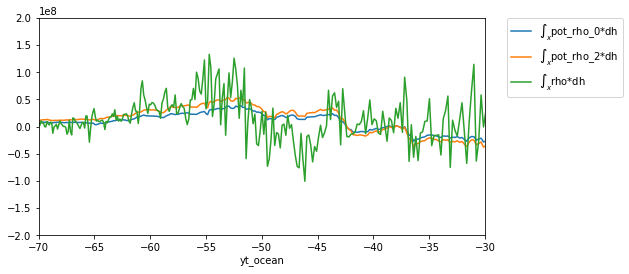

In [257]:
plt.figure(figsize=(8,4))
tmp1 = p0*dh    ## p0=pot_rho_0, dh generated from \int_z dzt
tmp2 = p2*dh    ## p2=pot_rho_2, dh generated from \int_z dzt
tmp3 = p*dh     ## p = rho, dh generated from \int_z dzt
tmp1.sum('xt_ocean').plot(label="$\int_x$pot_rho_0*dh")
tmp2.sum('xt_ocean').plot(label="$\int_x$pot_rho_2*dh")
tmp3.sum('xt_ocean').plot(label="$\int_x$rho*dh") 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([-2e8,2e8])
plt.xlim([-70,-30])

### Comments:
### 1. $\int_x$ pot_rho_0*dh magnitude is very small, do not understand the reason. 
### 2. use rho in-situ always give noisy results??

(-70, -30)

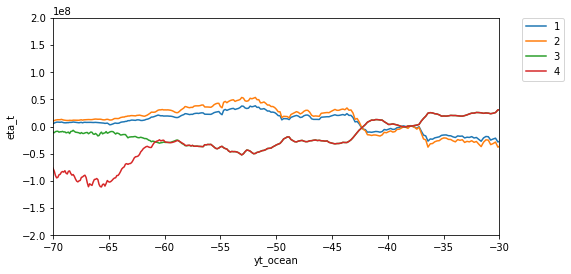

In [269]:
plt.figure(figsize=(8,4))
tmp1 = p0*dh    ## p0=pot_rho_0, dh generated from \int_z dzt
tmp2 = p2*dh    ## p2=pot_rho_2, dh generated from \int_z dzt
tmp3 = 1035*g*eta*dh     ## p = rho, dh generated from \int_z dzt
tmp4 = 1035*g*eta0*dh     ## p = rho, dh generated from \int_z dzt
tmp1.sum('xt_ocean').plot(label="1")
tmp2.sum('xt_ocean').plot(label="2")
tmp3.sum('xt_ocean').plot(label="3") 
tmp4.sum('xt_ocean').plot(label="4") 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([-2e8,2e8])
plt.xlim([-70,-30])

(-70, -30)

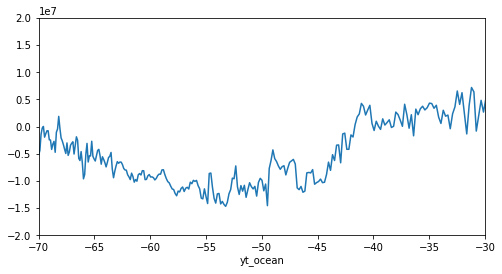

In [296]:
plt.figure(figsize=(8,4))
tmp1 = p0*dh+1035*g*eta*dh    ## p0=pot_rho_0*dh+1035*g*eta*dh, dh generated from \int_z dzt

tmp1.sum('xt_ocean').plot()
plt.ylim([-2e7,2e7])
plt.xlim([-70,-30])

### Comments: $\int_x \int_z(\rho_0*g*dz)*dh+\int_x 1035*g*\eta*dh$
### not sure whether it makes sense to get this two term together, but it might give some information.